# Leaky integrate-and-fire neuron model

The leaky integrate-and-fire (LIF) model is one of the simplest models of neuronal excitability. It is made up of the following equations:

$
C \frac{\mathrm{d}V_m}{\mathrm{d}t} = g_L(E_L - V_m) + I_{ext} \\
\mathrm{if}\quad V_m \geq V_{th},\quad V_m \rightarrow V_{reset}
$

The first one is the equation of a simple leaky integrator, whereas the second one accounts for the reset of the membrane voltage that occurs when the spiking threshold is crossed, i.e., a spike is emitted.

In this notebook we perform the integration of the model using Euler method and compute its analytical and experimental f-I curve.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

The parameters of the model:

In [2]:
C      = 400e-12  # [F]
tau    = 20e-3    # [s]
Rm     = tau / C  # [Ω]
gL     = 1 / Rm   # [S]
EL     = -70e-3   # [V]
Vth    = -54e-3   # [V]
Vreset = -65e-3   # [V]
I0     = 400e-12  # [A]
tarp   = 5e-3     # [s] refractory period

Here we inject a DC step of current:

In [13]:
np.random.randn?

In [16]:
dt = 0.01e-3
tstim = 200e-3
tbefore,tafter = 50e-3, 150e-3
tend = tbefore+tstim+tafter
t = np.r_[0 : tend : dt]
n_samples = t.size
Ie = np.zeros_like(t)
idx, = np.where((t>=tbefore) & (t<=tbefore+tstim))
Ie[idx] = I0
Ie[idx] = I0 + 100e-12*np.sin(2*np.pi*100*(t[idx]-t[idx[0]]))
Ie[idx] = I0 + 50e-12*np.random.randn(idx.size)
Vm = np.zeros_like(t)
Vm[0] = EL
t_last_spike = -1000
for i in range(n_samples-1):
    if t[i] - t_last_spike < tarp:
        Vm[i+1] = Vm[i]
    else:
        Vm[i+1] = Vm[i] + dt * (gL*(EL-Vm[i]) + Ie[i]) / C
    if Vm[i+1] >= Vth:
        Vm[i] = 10e-3
        Vm[i+1] = Vreset
        t_last_spike = t[i]

Plot the results:

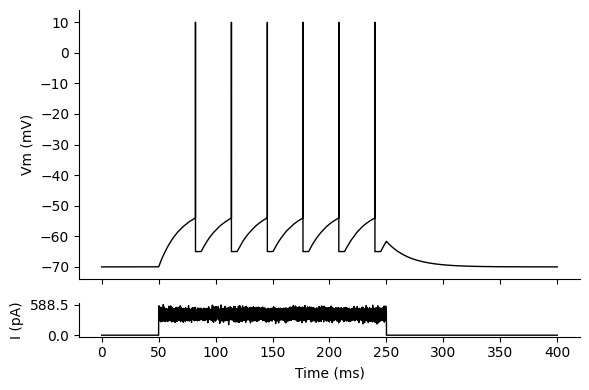

In [17]:
fig,ax = plt.subplots(2, 1, figsize=(6,4), sharex=True, height_ratios=(8,1))
ax[0].plot(t*1e3, Vm*1e3, 'k', lw=1)
ax[0].set_ylabel('Vm (mV)')
ax[1].plot(t*1e3, Ie*1e12, 'k', lw=1)
ax[1].set_yticks([0, Ie.max()*1e12])
ax[1].set_ylabel('I (pA)')
ax[-1].set_xlabel('Time (ms)')
sns.despine()
fig.tight_layout()

## Computation of the f-I curve

Being the LIF model linear, the f-I curve can be computed analytically. It is given by the following equation:

$f(I) = \left[\tau_{arp} - \frac{C}{g_L} \log \left( \frac{g_L(V_{th}-E_L)-I}{g_L(V_{reset}-E_L)-I}\right) \right]^{-1}$,

where $\tau_{arp}$ is the refractory period used above.

In [18]:
tend = 5
Imin,Imax,Istep = 100e-12, 1000e-12, 50e-12
Ie = np.r_[Imin : Imax+Istep/2 : Istep]
n_currents = Ie.size
n_spikes = np.zeros_like(Ie)
time = np.r_[0 : tend : dt]

for i in tqdm(range(Ie.size)):
    t_last_spike = -1000
    Vm = EL
    for t in time:
        if t - t_last_spike > tarp:
            Vm = Vm + dt * (gL*(EL-Vm) + Ie[i])/C
        if Vm >= Vth:
            t_last_spike = t;
            Vm = Vreset
            n_spikes[i] += 1
firing_rate_measured = n_spikes / tend

  0%|          | 0/19 [00:00<?, ?it/s]

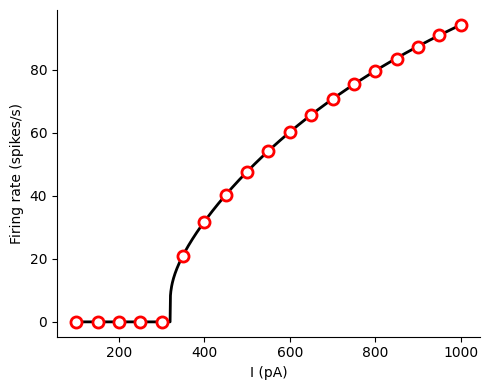

In [21]:
fig,ax = plt.subplots(1, 1, figsize=(5,4), sharex=True)
I = np.linspace(Imin, Imax, 1000)
firing_rate_theory = np.zeros_like(I)
E = EL + I / gL    # this is the equilibrium membrane potential for a given value of current
idx = E >= Vth     # for these values of current the cell emits spikes
firing_rate_theory[idx] = 1 / (tarp-C/gL*np.log((gL*(Vth-EL)-I[idx])/(gL*(Vreset-EL)-I[idx])))
ax.plot(I*1e12, firing_rate_theory, 'k', lw=2)
ax.plot(Ie*1e12, firing_rate_measured, 'ro', markerfacecolor='w', markersize=8, markeredgewidth=2)
ax.set_xlabel('I (pA)')
ax.set_ylabel('Firing rate (spikes/s)')
sns.despine()
fig.tight_layout()

#### Exercise

Add an excitatory synaptic conductance to the IF model described above based on the equation

$C \frac{\mathrm{d}V_m}{\mathrm{d}t} = g_L(E_L - V_m) + g_{exc}(E_{exc}-V_m)$

with $E_{exc} = 0\,\mathrm{mV}$. The excitatory conductance should satisfy the equation

$\tau_{exc}\frac{\mathrm{d}g_{exc}}{\mathrm{d}t} = −g_{exc}$

with $\tau_{exc} = 10\,\mathrm{ms}$. In addition, every time there is a presynaptic action potential, add an amount $\Delta g_{exc}$ to $g_{exc}$, with $\Delta g_{exc} = 1\,\mathrm{nS}$.

Plot $V_m(t)$ in one graph and the synaptic current, defined as $I_{exc} = g_{exc}(E_{exc}-V_m)$ in another, while triggering presynaptic action potentials at times 100, 200, 230, 300, 320, 400, and 410 ms. Explain what you see.

Now, in similar fashion, add an inhibitory synapse with $\Delta g_{inh} = \Delta g_{exc}$ and $E_{inh} = −70\,\mathrm{mV}$.